# **BURST**: Bayesian Uncertainty-driven Reinforcement Sampling Technique


---

## Overview

Our method integrates uncertainty estimation into the action selection process of a Deep Q-Network (DQN) agent. The agent uses a Bayesian neural network to model the Q-function, providing both expected Q-values and uncertainty estimates for each action. The uncertainty estimates guide the exploration strategy.

### Key Components

1. **Bayesian Deep Q-Network (BDQN)**: Extends the standard DQN with Bayesian neural networks to estimate uncertainty in Q-value predictions.
2. **Uncertainty-Driven Exploration**: Uses the uncertainty estimates to prioritize exploration of actions with high uncertainty.
3. **Thompson Sampling**: Implements Thompson Sampling for action selection, sampling from the posterior distribution over Q-values.

---

## Implementation

### Dependencies

```python
# Install required packages if not already installed
# !pip install numpy matplotlib seaborn torch gym


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from torch.distributions import Normal
from collections import deque
import random

### Agent Class

In [2]:
class BayesianNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(BayesianNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc_mu = nn.Linear(128, action_size)
        self.fc_logvar = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class BayesianDQNAgent:
    def __init__(self, state_size, action_size, config):
        self.state_size = state_size
        self.action_size = action_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = BayesianNetwork(state_size, action_size).to(self.device)
        self.target_net = BayesianNetwork(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=config['learning_rate'])
        self.memory = deque(maxlen=config['memory_size'])
        self.gamma = config['gamma']
        self.batch_size = config['batch_size']
        self.update_target_every = config['update_target_every']
        self.steps_done = 0
        self.config = config
        self.losses = []

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        self.policy_net.eval()
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            mu, logvar = self.policy_net(state)
            sigma = torch.exp(0.5 * logvar)
            dist = Normal(mu, sigma)
            q_values = dist.sample()
        action = q_values.argmax().item()
        return action

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        self.policy_net.train()
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*minibatch))
        states = torch.FloatTensor(states).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        dones = torch.FloatTensor(dones.astype(int)).unsqueeze(1).to(self.device)

        mu, logvar = self.policy_net(states)
        sigma = torch.exp(0.5 * logvar)
        dist = Normal(mu, sigma)
        q_values = dist.rsample()
        state_action_values = q_values.gather(1, actions)

        with torch.no_grad():
            mu_next, logvar_next = self.target_net(next_states)
            sigma_next = torch.exp(0.5 * logvar_next)
            dist_next = Normal(mu_next, sigma_next)
            q_values_next = dist_next.rsample()
            next_state_values = q_values_next.max(1)[0].unsqueeze(1)
            expected_state_action_values = (next_state_values * self.gamma * (1 - dones)) + rewards

        loss = F.mse_loss(state_action_values, expected_state_action_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.losses.append(loss.item())

        if self.steps_done % self.update_target_every == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        self.steps_done += 1

### Training Loop

In [3]:
# Configuration parameters
config = {
    'env_name': 'CartPole-v1',
    'episodes': 500,
    'max_steps': 500,
    'learning_rate': 0.001,
    'gamma': 0.99,
    'batch_size': 64,
    'memory_size': 10000,
    'update_target_every': 10,
    'render': False  # Set to True to render the environment
}

# Initialize environment and agent
env = gym.make(config['env_name'])
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = BayesianDQNAgent(state_size, action_size, config)

# Training loop
rewards = []
for e in range(config['episodes']):
    state = env.reset()
    total_reward = 0

    for time_t in range(config['max_steps']):
        if config['render']:
            env.render()

        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        agent.replay()

        if done:
            rewards.append(total_reward)
            print(f"Episode: {e+1}/{config['episodes']}, Score: {total_reward}")
            break

env.close()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 1/500, Score: 24.0
Episode: 2/500, Score: 10.0
Episode: 3/500, Score: 43.0
Episode: 4/500, Score: 22.0
Episode: 5/500, Score: 15.0
Episode: 6/500, Score: 16.0
Episode: 7/500, Score: 21.0
Episode: 8/500, Score: 18.0
Episode: 9/500, Score: 11.0
Episode: 10/500, Score: 10.0
Episode: 11/500, Score: 10.0
Episode: 12/500, Score: 9.0
Episode: 13/500, Score: 11.0
Episode: 14/500, Score: 9.0
Episode: 15/500, Score: 10.0
Episode: 16/500, Score: 10.0
Episode: 17/500, Score: 10.0
Episode: 18/500, Score: 11.0
Episode: 19/500, Score: 9.0
Episode: 20/500, Score: 10.0
Episode: 21/500, Score: 11.0
Episode: 22/500, Score: 9.0
Episode: 23/500, Score: 10.0
Episode: 24/500, Score: 11.0
Episode: 25/500, Score: 10.0
Episode: 26/500, Score: 8.0
Episode: 27/500, Score: 9.0
Episode: 28/500, Score: 10.0
Episode: 29/500, Score: 10.0
Episode: 30/500, Score: 9.0
Episode: 31/500, Score: 10.0
Episode: 32/500, Score: 10.0
Episode: 33/500, Score: 10.0
Episode: 34/500, Score: 10.0
Episode: 35/500, Score: 9.0
Ep

### Experiments


*   **Environment**: We use the CartPole-v1 environment from OpenAI Gym to validate our approach.
*   **Baseline**: For comparison, we can run a standard DQN agent with epsilon-greedy exploration.



In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size, config):
        self.state_size = state_size
        self.action_size = action_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        ).to(self.device)
        self.target_net = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        ).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=config['learning_rate'])
        self.memory = deque(maxlen=config['memory_size'])
        self.gamma = config['gamma']
        self.batch_size = config['batch_size']
        self.update_target_every = config['update_target_every']
        self.steps_done = 0
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.losses = []

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action_values = self.policy_net(state)
        return action_values.argmax().item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        self.policy_net.train()
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*minibatch))
        states = torch.FloatTensor(states).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        dones = torch.FloatTensor(dones.astype(int)).unsqueeze(1).to(self.device)

        # Compute current Q estimates
        state_action_values = self.policy_net(states).gather(1, actions)

        # Compute target Q values
        with torch.no_grad():
            next_state_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
            expected_state_action_values = (next_state_values * self.gamma * (1 - dones)) + rewards

        # Compute loss
        loss = F.mse_loss(state_action_values, expected_state_action_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.losses.append(loss.item())

        # Update target network
        if self.steps_done % self.update_target_every == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.steps_done += 1

## **Results**


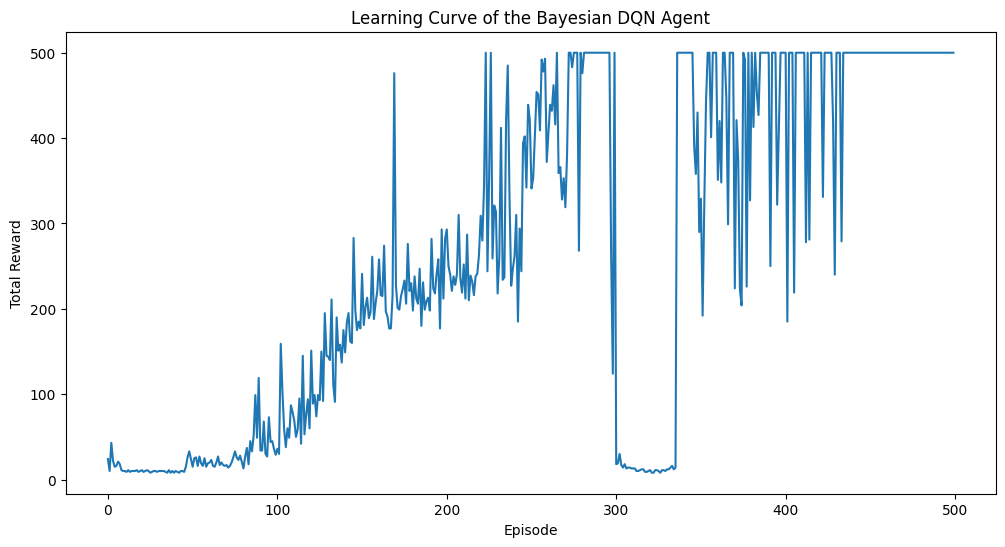

In [5]:
# Plot the learning curve
plt.figure(figsize=(12,6))
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curve of the Bayesian DQN Agent')
plt.show()

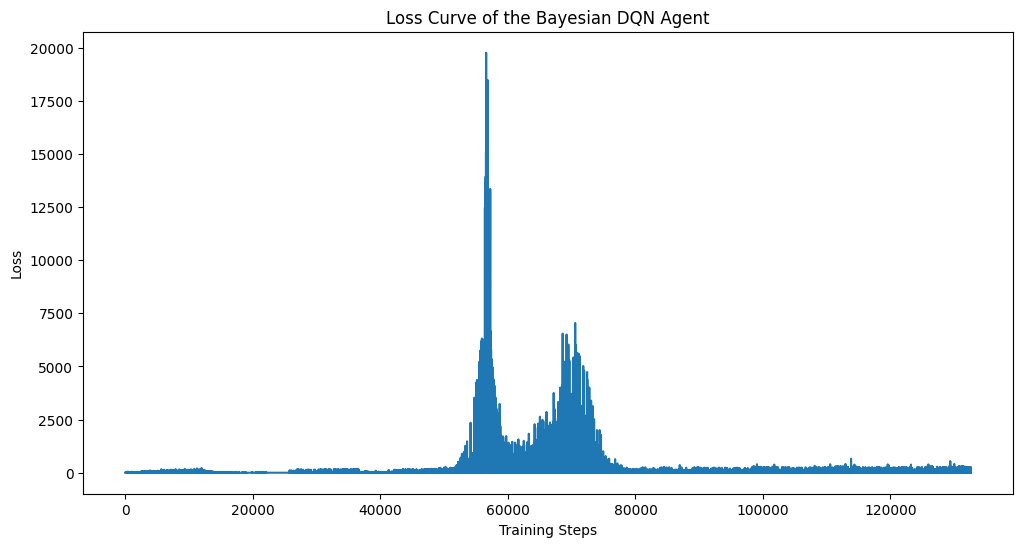

In [6]:
# Plot the loss curve
plt.figure(figsize=(12,6))
plt.plot(agent.losses)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Loss Curve of the Bayesian DQN Agent')
plt.show()

## Conclusion
This project presents an advanced RL agent that effectively addresses the exploration-exploitation dilemma through uncertainty estimation. The use of Bayesian neural networks and Thompson Sampling provides a principled approach to exploration, leading to improved learning efficiency and performance.


# Reference

- Osband, I., et al. (2016). Deep Exploration via Bootstrapped DQN. NIPS.
